In [103]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, leaves_list
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.hierarchy import fcluster

from model import LDM

In [113]:
class create_plots:
    def __init__(self, Aij, links, drug_emb, effect_emb, dim_reduction = "defualt", seed = None):
        self.Aij = Aij.detach().cpu().numpy()
        self.links = links.detach().cpu().numpy()
        self.drug_emb = drug_emb.detach().cpu().numpy()
        self.effect_emb = effect_emb.detach().cpu().numpy()
        self.dim_reduction = dim_reduction.lower()

        self.n_drugs = self.drug_emb.shape[0]
        self.n_effects = self.effect_emb.shape[0]

        self.seed = seed
        self.__set_seed(seed)

    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def create_network(self):
        G = nx.Graph()

        for i in range(self.n_drugs):
            G.add_node(f"Drug_{i}", bipartite=0)
        for j in range(self.n_effects):
            G.add_node(f"Effect_{j}", bipartite=1)

        for i in range(self.n_drugs):
            for j in range(self.n_effects):
                if self.links[i,j] != 0:  
                    G.add_edge(f"Drug_{i}", f"Effect_{j}", weight=self.links[i,j])
        
        return G
    
    def reduce_dimensionality(self):
        """Reduce dimensionality using either the first two components or t-SNE."""
        if self.dim_reduction == "tsne":
            tsne = TSNE(n_components=2, perplexity=(self.n_drugs-1), random_state=self.seed)
            drugs_2d = tsne.fit_transform(self.drug_emb)
            effects_2d = tsne.fit_transform(self.effect_emb)
            return drugs_2d, effects_2d
        
        elif self.dim_reduction == "pca":
            pca = PCA(n_components=2)
            drugs_2d = pca.fit_transform(self.drug_emb)
            effects_2d = pca.fit_transform(self.effect_emb)
            return drugs_2d, effects_2d
        
        elif self.dim_reduction == "default":
            drugs_2d = self.drug_emb[:, :2]
            effects_2d = self.effect_emb[:,:2]
            return drugs_2d, effects_2d
        else: 
            drugs_2d = self.drug_emb[:, :2]
            effects_2d = self.effect_emb[:,:2]
            return drugs_2d, effects_2d
    
    def tsne_plot(self):
        drugs_2d, effects_2d = self.reduce_dimensionality()
        plt.figure(figsize=(10, 6))
        plt.scatter(drugs_2d[:, 0], drugs_2d[:, 1], label="Drugs", color='blue', alpha=0.6)
        plt.scatter(effects_2d[:, 0], effects_2d[:, 1], label="Side Effects", color='red', alpha=0.6)

        plt.legend()
        plt.title("t-SNE Representation of Drug and Side Effect Embeddings")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(True)
        plt.show()
        return drugs_2d, effects_2d

    def links_space(self):
        G = self.create_network()
        drugs_2d, effects_2d = self.reduce_dimensionality()
        pos = {}
        for i in range(self.n_drugs):
            pos[f"Drug_{i}"] = (drugs_2d[i, 0], drugs_2d[i, 1])  # 2D position based on first two embedding dims
        
        # Position effects based on their embeddings
        for j in range(self.n_effects):
            pos[f"Effect_{j}"] = (effects_2d[j, 0], effects_2d[j, 1])

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=False, node_size=10, node_color=["skyblue" if "Drug" in node else "lightgreen" for node in G.nodes], font_size=10, font_weight='bold', edge_color='gray')

        # Display edge weights (probabilities) as labels
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.title('Drug-Side Effect Network based on Embeddings and Probit Output')
        plt.show()

    def links_space_clustered(self):
        G = self.create_network()
        drugs_2d, effects_2d = self.reduce_dimensionality()
        
        # Dendrogram clustering for coloring
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')
        drug_clusters = fcluster(drug_linkage, t=4, criterion='maxclust')
        effect_clusters = fcluster(effect_linkage, t=4, criterion='maxclust')
        
        drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        effect_colors = [cm.Set2(i % 8) for i in effect_clusters]

        # Positions
        pos = {}
        for i in range(self.n_drugs):
            pos[f"Drug_{i}"] = (drugs_2d[i, 0], drugs_2d[i, 1])
        for j in range(self.n_effects):
            pos[f"Effect_{j}"] = (effects_2d[j, 0], effects_2d[j, 1])

        # Assign cluster-based node colors
        node_colors = []
        for node in G.nodes:
            if "Drug" in node:
                idx = int(node.split("_")[1])
                node_colors.append(drug_colors[idx])
            else:
                idx = int(node.split("_")[1])
                node_colors.append(effect_colors[idx])

        # Plot
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors,
                font_size=10, font_weight='bold', edge_color='gray')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

        plt.title('Drug-Side Effect Network Colored by Dendrogram Clusters')
        plt.show()
    
    def simple_links(self):
        G = self.create_network()

        pos = {}
        pos.update((node, (1, index)) for index, node in enumerate(f"Drug_{i}" for i in range(self.n_drugs)))  # Position for drugs
        pos.update((node, (2, index)) for index, node in enumerate(f"Effect_{j}" for j in range(self.n_effects)))  # Position for effects

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_size=500, node_color=["skyblue" if "Drug" in node else "lightgreen" for node in G.nodes], font_size=10, font_weight='bold', edge_color='gray')

        # Display edge weights (optional)
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.title('Drug-Side Effect Network')
        plt.show()

    def dendrograms(self):
        drug_distance_matrix = squareform(pdist(self.drug_emb, metric="euclidean"))
        effect_distance_matrix = squareform(pdist(self.effect_emb, metric="euclidean"))
        
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        plt.figure(figsize=(20, 10))
        dendrogram(drug_linkage, labels=[f"Drug {i}" for i in range(len(self.drug_emb))], leaf_rotation=90)
        plt.xlabel("Drugs")
        plt.ylabel("Distance")
        plt.title("Drug Hierarchical Clustering Dendrogram")
        plt.show()

        plt.figure(figsize=(20, 10))
        dendrogram(effect_linkage, labels=[f"SE {i}" for i in range(len(self.effect_emb))], leaf_rotation=90)
        plt.xlabel("Side Effects")
        plt.ylabel("Distance")
        plt.title("Side Effect Hierarchical Clustering Dendrogram")
        plt.show()

    def reorder_matrix(self):
        drug_distance_matrix = squareform(pdist(self.drug_emb, metric="euclidean"))
        effect_distance_matrix = squareform(pdist(self.effect_emb, metric="euclidean"))
        
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        # Find new order
        drug_order = leaves_list(drug_linkage)
        effect_order = leaves_list(effect_linkage)

        Aij_reordered = self.Aij[drug_order, :][:, effect_order]

        drug_adj = self.Aij @ self.Aij.T  # Drug-drug adjacency
        effect_adj = self.Aij.T @ self.Aij  # Effect-effect adjacency

        drug_adj_reordered = drug_adj[drug_order, :][:, drug_order]
        effect_adj_reordered = effect_adj[effect_order, :][:, effect_order]
        return Aij_reordered, drug_adj_reordered, effect_adj_reordered, drug_adj, effect_adj
    
    def plot_reorder(self):
        Aij_reordered, drug_adj_reordered, effect_adj_reordered, drug_adj, effect_adj = self.reorder_matrix()
        plt.figure(figsize=(20,20))
        plt.subplot(3,2,1)
        plt.imshow(self.Aij, aspect='auto', cmap='viridis')
        plt.title("Original Aij")
        plt.xlabel("Side Effects")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(3,2,2)
        plt.imshow(Aij_reordered, aspect='auto', cmap='viridis')
        plt.title("Reordered Aij")
        plt.xlabel("Side Effects")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(3,2,3)
        plt.imshow(drug_adj, aspect='auto', cmap='viridis')
        plt.title("Original Drug-adjacency matrix")
        plt.xlabel("Drugs")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(3,2,4)
        plt.imshow(drug_adj_reordered, aspect='auto', cmap='viridis')
        plt.title("Reordered Drug-adjacency matrix")
        plt.xlabel("Drugs")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(3,2,5)
        plt.imshow(effect_adj, aspect='auto', cmap='viridis')
        plt.title("Original Side Effect-adjacency matrix")
        plt.xlabel("Side Effects")
        plt.ylabel("Side Effects")
        plt.colorbar()

        plt.subplot(3,2,6)
        plt.imshow(effect_adj_reordered, aspect='auto', cmap='viridis')
        plt.title("Reordered Side Effect-adjacency matrix")
        plt.xlabel("Side Effects")
        plt.ylabel("Side Effects")
        plt.colorbar()
        plt.show()
        

In [8]:
def plot_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Function During Training')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 17
Aij = torch.tensor([[0, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
                    [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
                    [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
                    [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
                    [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
                    [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]],dtype=torch.float32, device=device) #column: side effect, row:drug, value: frequency (ordinal)
n_epochs = 500
lr = 0.01
seed = 20
model = LDM(Aij, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

In [100]:
links, ordinal_vals = model.predict_categories()
drug_emb, effect_emb = model.get_embeddings()

In [114]:
plots1 = create_plots(links, Aij, drug_emb, effect_emb, dim_reduction="default", seed = 10)

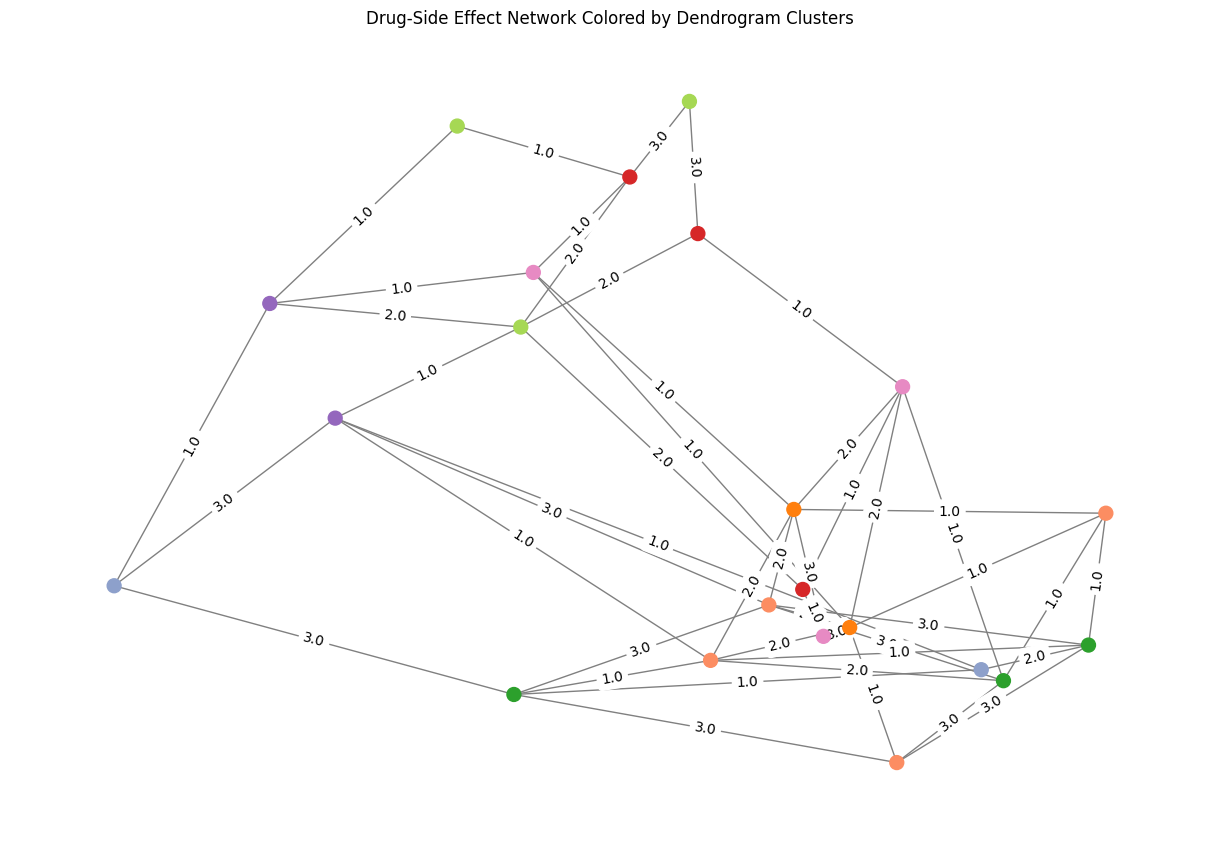

In [115]:
plots1.links_space_clustered()

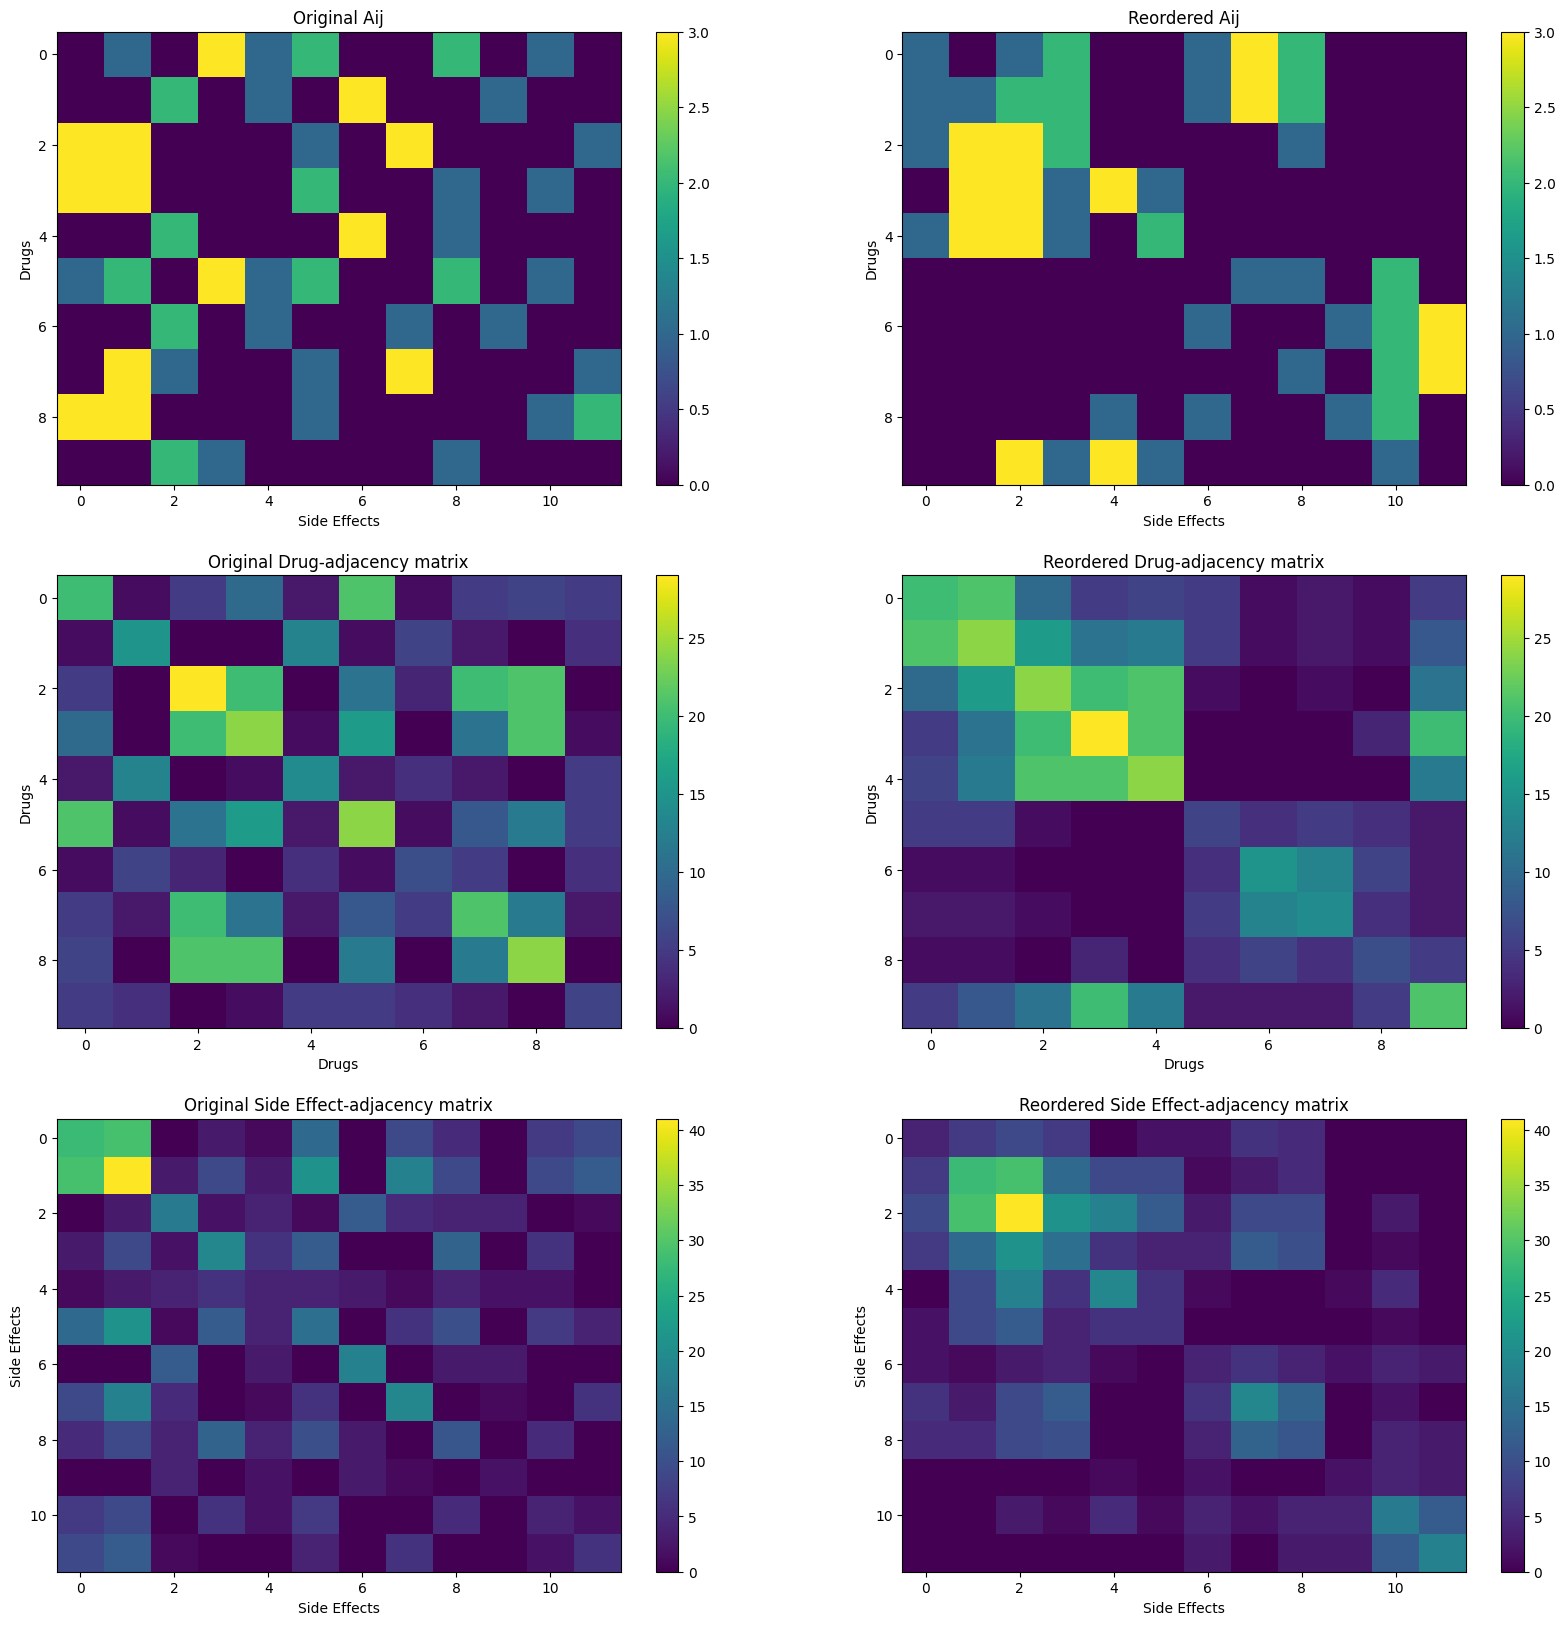

In [102]:
plots1.plot_reorder()

### real data

In [116]:
def load_data(path_to_csv, device):
    df = pd.read_csv(path_to_csv, index_col=0)
    Aij = torch.tensor(df.values, dtype=torch.float32).to(device)
    return Aij

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/Users/christine/Bachelor/src/data/adj_matrix.csv" 
Aij_real = load_data(csv_path, device)
print(Aij_real.shape)

torch.Size([968, 3964])


In [ ]:
Aij_real

In [117]:
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train() 

In [118]:
links, ordinal_vals = model.predict_categories()
drug_emb, effect_emb = model.get_embeddings()

In [119]:
plots1 = create_plots(links, Aij_real, drug_emb, effect_emb, dim_reduction="default", seed = 10)

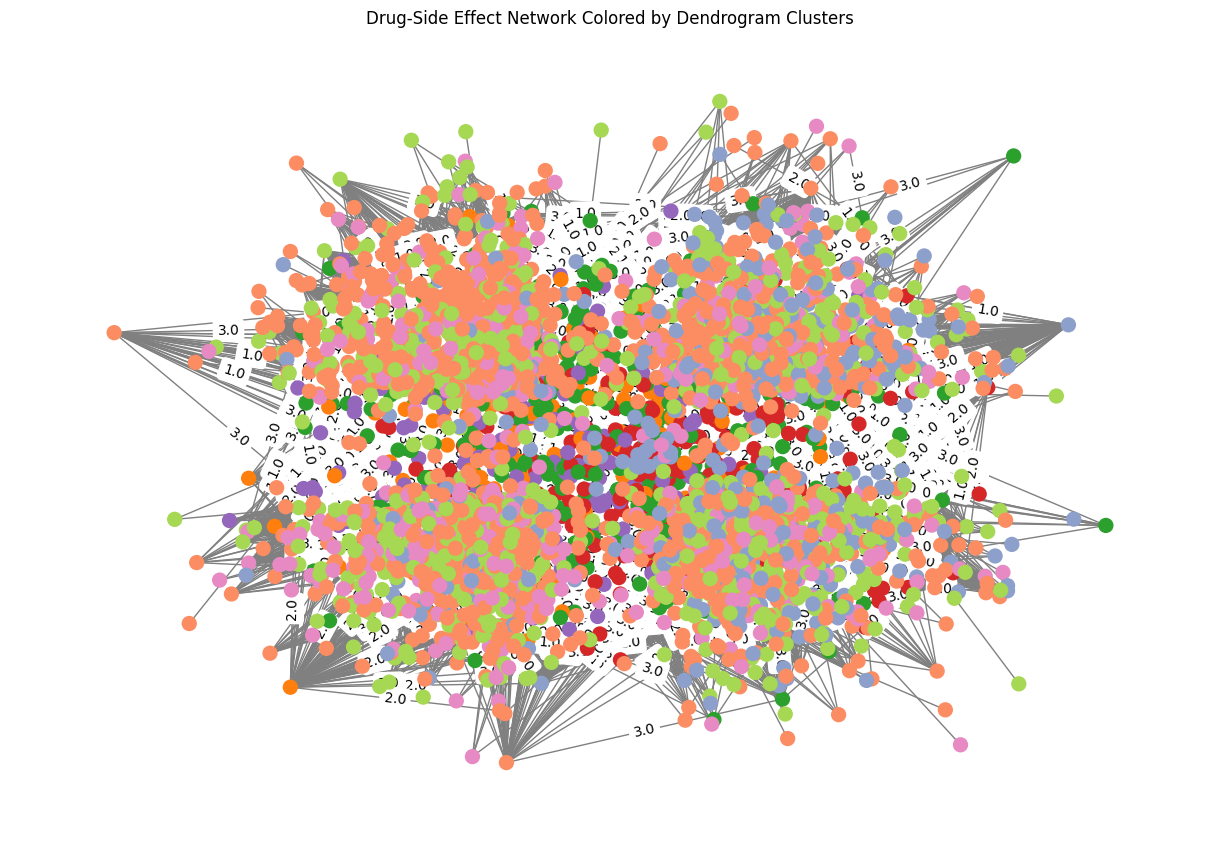

In [123]:
plots1.links_space_clustered()

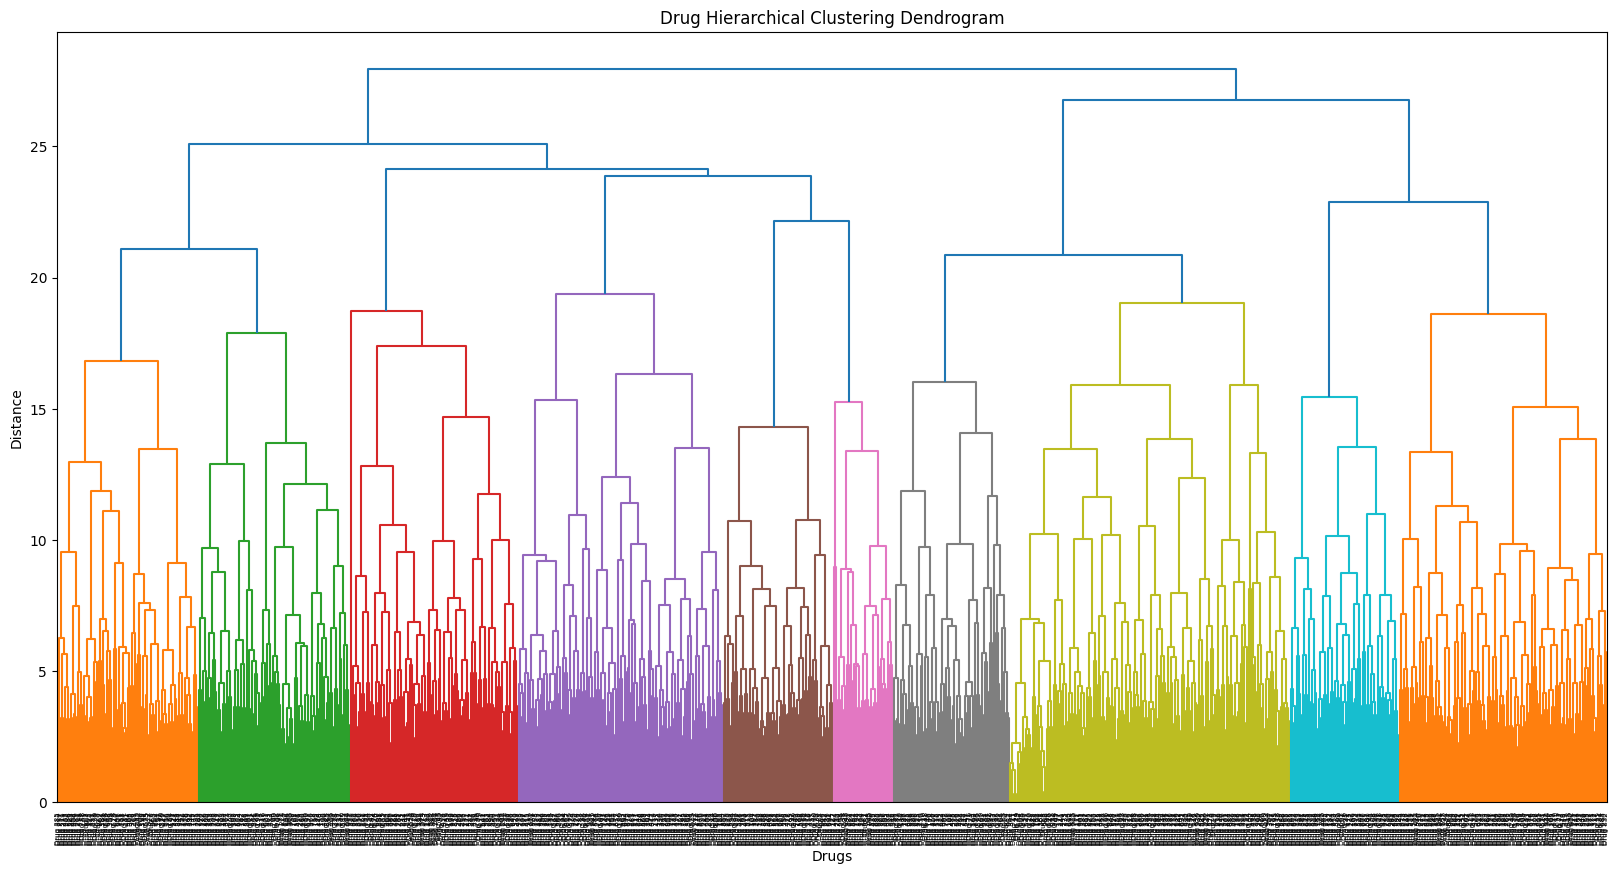

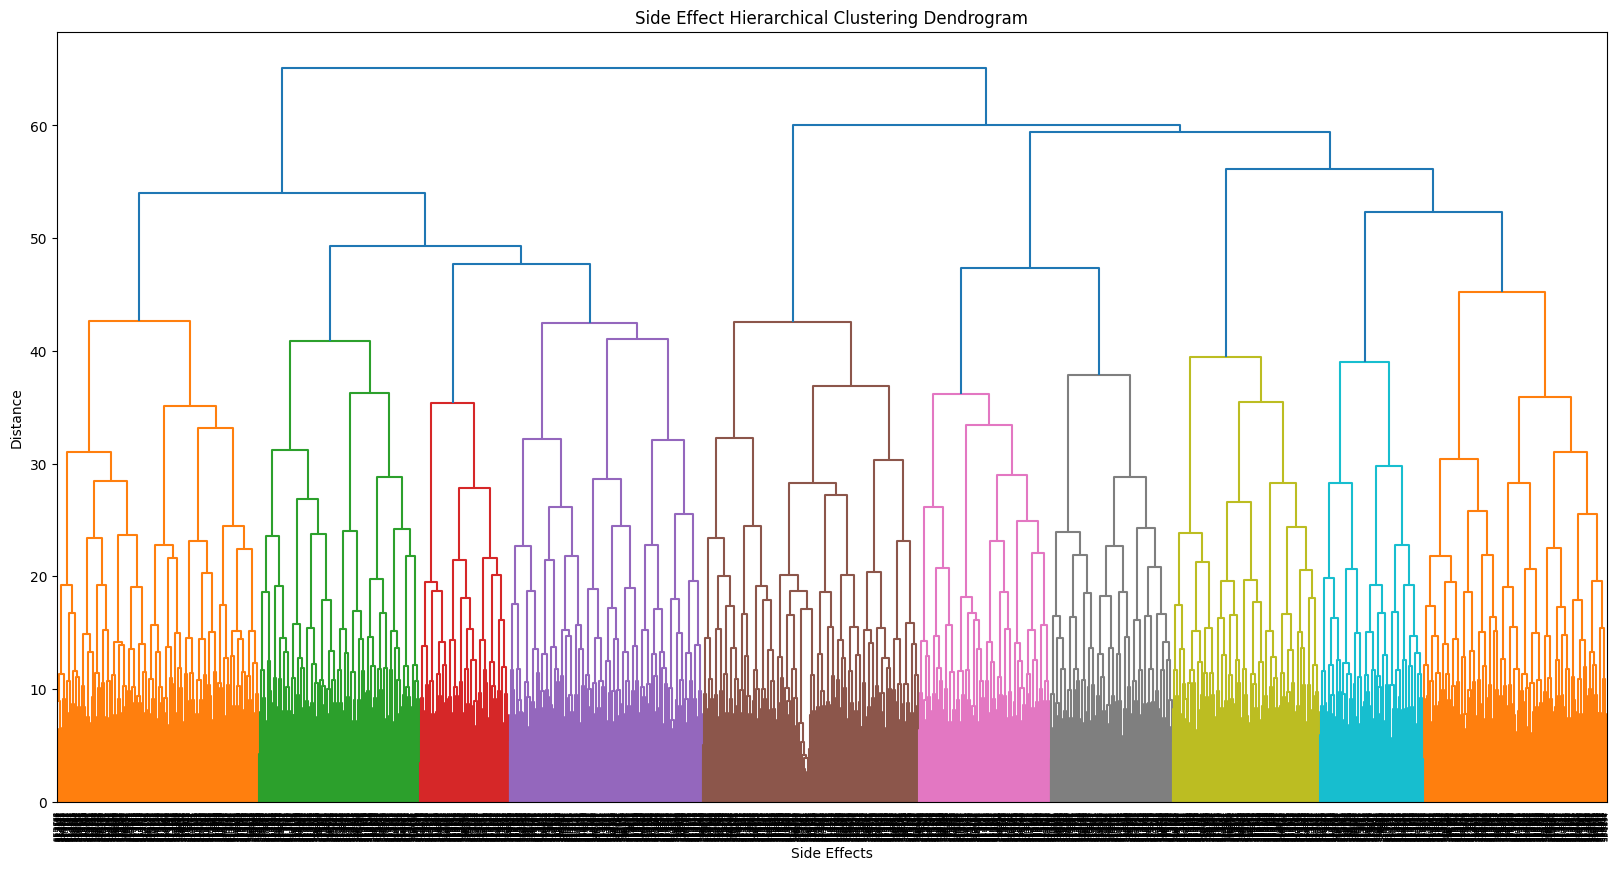

In [124]:
plots1.dendrograms()

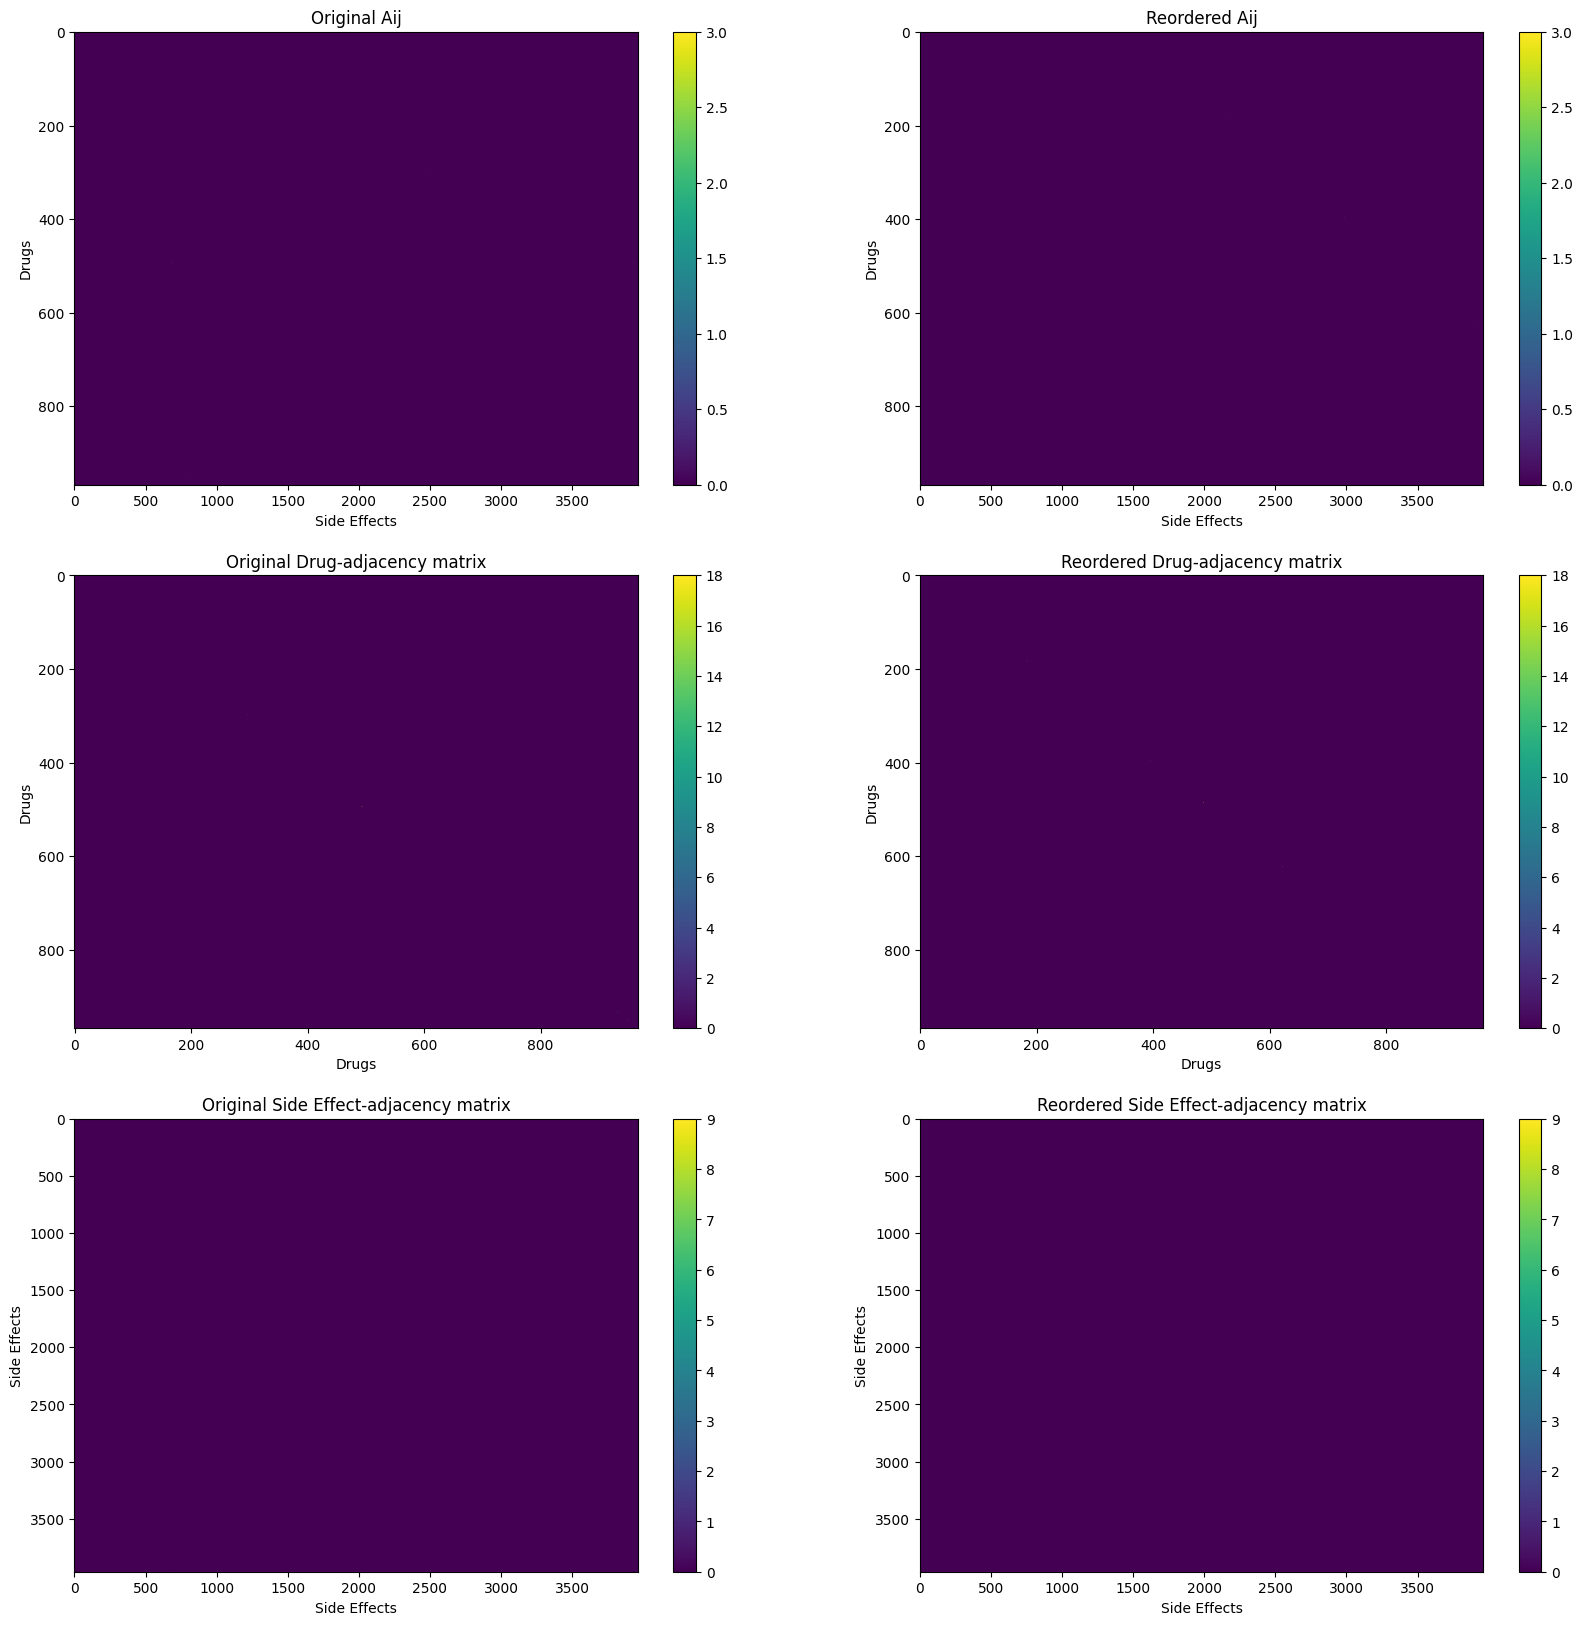

In [125]:
plots1.plot_reorder()